# The code is divided into the following sections:
<br> 1) Importing the essential libraries
<br> 2) Defining functions
<br> 3) Importing the datasets
<br> 4) Feature engineering using factors and price information
<br> 5) Plotting them to get a better understanding of variables
<br> 6) Running Logit on macro factors to identify the sign and economic intuition
<br> 7) Defining single factor and price models along with Buy & Hold Strategy
<br> 8) Creating the multi-factor timing model
<br> 9) Tabulating the strategies along with returns, drawdown, standard deviation and Sharpe ratios
<br> 10) Analyzing the signals given by final utilized strategies in multifactor approach

# 1.Libraries
<br>- Imports important libraries such as numpy, pandas, matplotlib
<br>- Suppresses warnings from appearing in the code

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore")

# 2.Functions
<br>- Contains first_day function which returns the value corresponding to first day of the month
<br>- Contains functions which calculates annual returns, max drawdown and annual std of the input series

In [2]:
# Returns the first instance of the dataframe
def first_day(dataframe):
    return dataframe[0]

In [3]:
# Returns returns, dd and std for the strategy
def annualized_return(series, periods_per_year=12):
    total_return = series.iloc[-1]
    num_periods = len(series)
    return (total_return ** (periods_per_year / num_periods)) - 1

def max_drawdown(series):
    cumulative_max = series.cummax()
    drawdown = (series / cumulative_max) - 1
    return drawdown.min()

def annualized_std(series, periods_per_year=12):   
    std_dev = series.pct_change().std()
    annualized_std_dev = std_dev * (periods_per_year ** 0.5)
    return annualized_std_dev

# 3.Datasets
<br>- Imports 6 datasets containing information about price and macro factors
<br>- Fills the missing values with last available numbers
<br>- Resamples the daily data to monthly timeframe

In [4]:
# Importing all datasets
price = pd.read_excel('S&P500.xlsx').set_index('DATE')
economic_growth = pd.read_excel('CFNAI.xlsx').set_index('DATE')
inflation = pd.read_excel('CPIAUCSL.xlsx').set_index('DATE')
international_trade = pd.read_excel('DTWEXBGS.xlsx').set_index('DATE')
monetary_policy = pd.read_excel('DGS2.xlsx').set_index('DATE')
risk_appetite = pd.read_excel('BAMLH0A0HYM2.xlsx').set_index('DATE')

In [5]:
# Replacing missing values by preceding values
for dataframe in [price, economic_growth, inflation, international_trade, monetary_policy, risk_appetite]:
    dataframe.fillna(method='ffill', inplace=True)

In [6]:
# Resampling daily data to monthly data
price = price.resample('MS').apply(first_day)
international_trade = international_trade.resample('MS').apply(first_day)
monetary_policy = monetary_policy.resample('MS').apply(first_day)
risk_appetite = risk_appetite.resample('MS').apply(first_day)

# 4.Manipulations
<br>- Calculates the % returns of the index
<br>- Convers the macro factors into useful features by taking annual percent changes and differences
<br>- Adds 20, 50 and 200 DEMA along with Daily/Weekly MACD from the price history
<br>- Combines all the datasets and drops the rows with NaN values due to time shifts

In [7]:
price['price_1M_ret_prev'] = price['Price'].pct_change(periods=1) # monthly % chg
price['price_1M_ret_curr'] = price['price_1M_ret_prev'].shift(-1) # shifting by -1 to get curr returns
price['returns'] = price['price_1M_ret_curr'] > 0 # getting True where returns are positive
price['returns'] = price['returns'].astype(int) # converting boolean value to integers

economic_growth.rename(columns = {'CFNAI':'growth'}, inplace = True) # directly used
inflation['inf_12M_chg'] = inflation['CPIAUCSL'].pct_change(periods=12) # annual % chg
international_trade['trade_12M_chg'] = international_trade['DTWEXBGS'].pct_change(periods=12) # annual % chg

monetary_policy['mon_1M_chg'] = monetary_policy['DGS2'].pct_change(periods=1) # monthly % chg
monetary_policy['mon_1M_diff'] = monetary_policy['DGS2'].rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0]) # monthly diff

risk_appetite['risk_12M_chg'] = risk_appetite['BAMLH0A0HYM2'].pct_change(periods=12) # annual % chg
risk_appetite['risk_12M_diff'] = risk_appetite['BAMLH0A0HYM2'].rolling(window=12).apply(lambda x: x.iloc[11] - x.iloc[0]) # annual diff

In [8]:
# Assuming a 5 day week 20 daily = 4 weekly and so on
price['20DEMA'] = price['Price'].ewm(span=4, adjust=True).mean() # 20 ewma
price['50DEMA'] = price['Price'].ewm(span=10, adjust=True).mean() # 50 ewma
price['200DEMA'] = price['Price'].ewm(span=40, adjust=True).mean() # 200 ewma
price['MACD_daily'] = price['Price'].ewm(span=2, adjust=True).mean() - price['Price'].ewm(span=5, adjust=True).mean() # macd daily
price['MACD_weekly'] = price['Price'].ewm(span=10, adjust=True).mean() - price['Price'].ewm(span=25, adjust=True).mean() # macd weekly

In [9]:
# Combining all the dataframes
data_final = pd.concat([price, economic_growth, inflation, international_trade, monetary_policy, risk_appetite], axis=1)
data_final.drop(columns=['price_1M_ret_prev','CPIAUCSL','DTWEXBGS','DGS2','BAMLH0A0HYM2'], inplace=True)

data_final = data_final.iloc[12:-1,:] # Removing NaN values due to 12 period changes and curr price returns

# 5.Plots factors
<br>- Plots the feature engineered from macro factors to decide cut-offs for long index vs cash
<br>- Plots the EMAs along with the price history of index

array([[<AxesSubplot:xlabel='DATE'>],
       [<AxesSubplot:xlabel='DATE'>],
       [<AxesSubplot:xlabel='DATE'>],
       [<AxesSubplot:xlabel='DATE'>],
       [<AxesSubplot:xlabel='DATE'>],
       [<AxesSubplot:xlabel='DATE'>],
       [<AxesSubplot:xlabel='DATE'>],
       [<AxesSubplot:xlabel='DATE'>]], dtype=object)

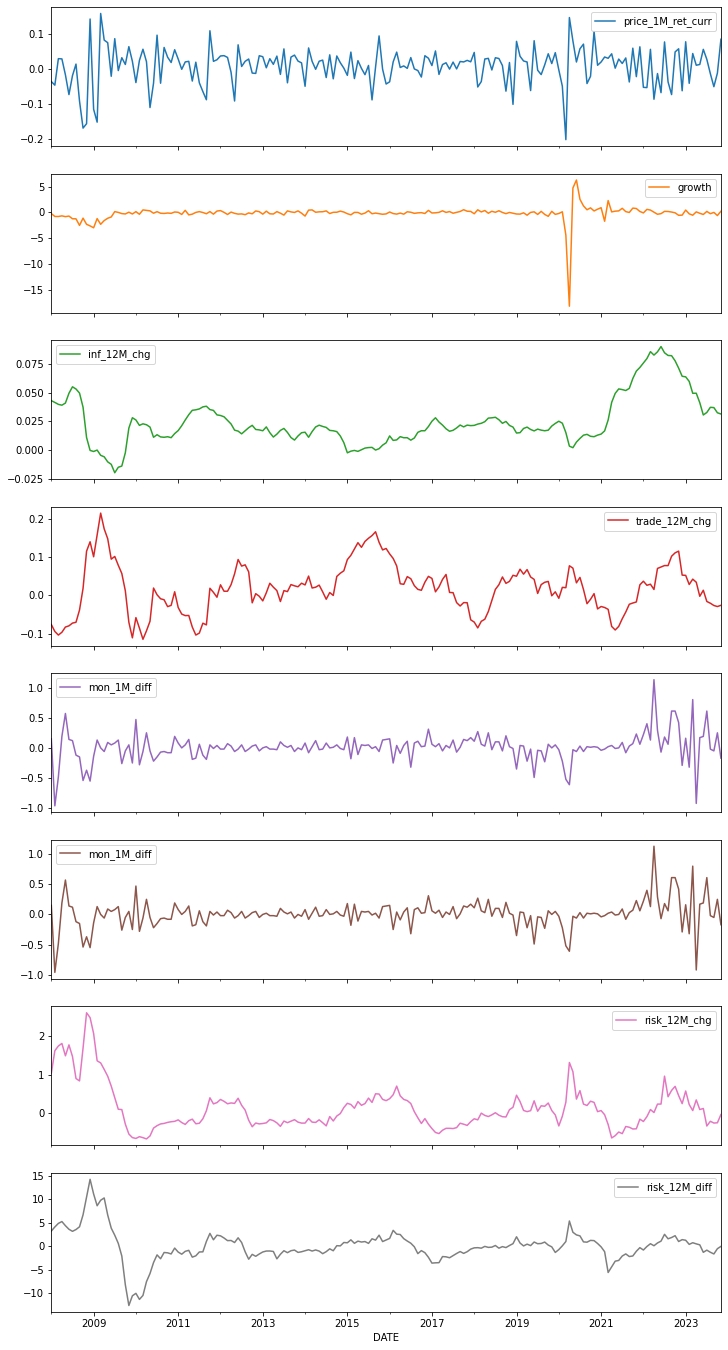

In [10]:
data_final[['price_1M_ret_curr','growth','inf_12M_chg','trade_12M_chg','mon_1M_diff','mon_1M_diff',
            'risk_12M_chg','risk_12M_diff']].plot(subplots=True, layout=(8,1), figsize=(12, 24))

<AxesSubplot:xlabel='DATE'>

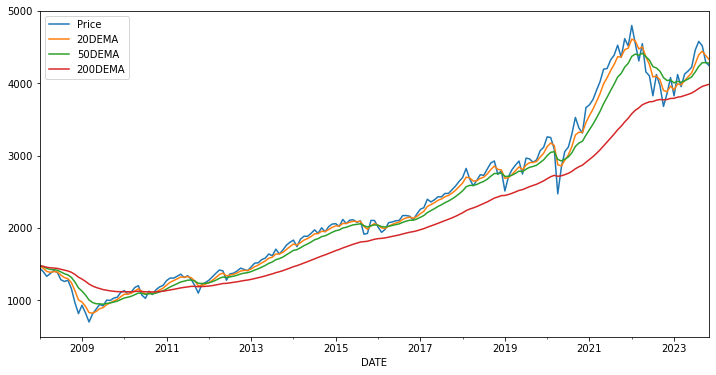

In [11]:
data_final[['Price','20DEMA','50DEMA','200DEMA']].plot(figsize=(12, 6))

# 6.Regressions
<br>- Define Logit models to capture the sign of index with respect to macro factors for economic intuition
<br>- Corrected sign for monetary policy while building the single factor model

In [12]:
reg = {} # store strategy name as key and (coeff, r2) as values

In [13]:
# Running regressions to check for signs for macro factors
for col in data_final.columns[8:]:
    regressor = LogisticRegression()
    regressor.fit(data_final[col].values.reshape(-1,1), data_final.returns.values.reshape(-1,1))
    
    reg[col] = (regressor.coef_, 
                 regressor.score(data_final[col].values.reshape(-1,1), data_final.returns.values.reshape(-1,1)))

In [14]:
table = []

for strategy, metrics in reg.items():
    coeff, r2 = metrics
    table.append([strategy, f"{coeff[0][0]:.6f}", f"{r2:.6f}"])

# Define the headers
headers = ["Strategy", "Coefficient", "R-squared"]

# Print the table
print(tabulate(table, headers=headers, tablefmt="grid"))

# growth / inflation / trade us dollar / risk app seems to have the right sign
# monetary policy seems to have the wrong sign (reversed in code to get correct returns)

+---------------+---------------+-------------+
| Strategy      |   Coefficient |   R-squared |
+===============+===============+=============+
| growth        |      0.074876 |    0.633508 |
+---------------+---------------+-------------+
| inf_12M_chg   |     -0.311678 |    0.638743 |
+---------------+---------------+-------------+
| trade_12M_chg |      0.19183  |    0.638743 |
+---------------+---------------+-------------+
| mon_1M_chg    |     -1.28079  |    0.65445  |
+---------------+---------------+-------------+
| mon_1M_diff   |     -0.495416 |    0.638743 |
+---------------+---------------+-------------+
| risk_12M_chg  |     -0.33046  |    0.643979 |
+---------------+---------------+-------------+
| risk_12M_diff |     -0.058116 |    0.638743 |
+---------------+---------------+-------------+


# 7.1. Single Factor Models
<br>- Built 7 single factor models based on macro features with signs corrected for economic intuition
<br>- Built 8 price models for market timing using EMAs and MACD
<br>- Built the model for Buy and Hold Index Strategy
<br>- Plot and tabulated the results for 15 strategies

In [15]:
ret_dd = {} # store strategy name as key and (return, drawdown, std) as values

In [16]:
for col in data_final.columns[8:]:
    if col in ['mon_1M_chg', 'mon_1M_diff']: # dealing with economic intuition vs regression results
        sign = -1 if reg[col][0] > 0 else 1
    elif col == 'inf_12M_chg': # setting sign = 1 to deal with 0.025 value (long index vs cash)
        sign = 1
    else:
        sign = 1 if reg[col][0] > 0 else -1
        
    data_final['dummy'] = sign * data_final[col] # setting dummy variable to decide for long index vs cash
    
    if col == 'inf_12M_chg': # using 0.025 for inflation due to above plots; 0 as border for others
        data_final['Strategy_' + col] = data_final['dummy'] < 0.025
    else:
        data_final['Strategy_' + col] = data_final['dummy'] > 0
        
    data_final['Strategy_' + col] = data_final['Strategy_' + col].astype(int)
    data_final['Return_' + col] = data_final['Strategy_' + col] * data_final['price_1M_ret_curr']
    data_final['Cumulative_Return_' + col] = (1 + data_final['Return_' + col]).cumprod()
    
    ret_dd[col] = (annualized_return(data_final['Cumulative_Return_' + col]) * 100,
                   max_drawdown(data_final['Cumulative_Return_' + col]) * 100,
                   annualized_std(data_final['Cumulative_Return_' + col]) * 100)
    
data_final.drop(columns=['dummy'], inplace=True)

# 7.2. Price Models

In [17]:
data_final[['Strategy_20DEMA','Strategy_50DEMA','Strategy_200DEMA','Strategy_Crossover1',
            'Strategy_Crossover2','Strategy_Daily_MACD','Strategy_Weekly_MACD','Strategy_MACD']] = 0

for row in range(len(data_final)): # looping through each row of the dataset
    if data_final['Price'][row] >= data_final['20DEMA'][row]: # price above 20 DEMA
        data_final['Strategy_20DEMA'][row] = 1
    
    if data_final['Price'][row] >= data_final['50DEMA'][row]: # price above 50 DEMA 
        data_final['Strategy_50DEMA'][row] = 1
        
    if data_final['Price'][row] >= data_final['200DEMA'][row]: # price above 200 DEMA
        data_final['Strategy_200DEMA'][row] = 1
        
    if data_final['20DEMA'][row] >= data_final['50DEMA'][row]: # 20 DEMA above 50 DEMA
        data_final['Strategy_Crossover1'][row] = 1
        
    if data_final['50DEMA'][row] >= data_final['200DEMA'][row]: # 50 DEMA above 200 DEMA
        data_final['Strategy_Crossover2'][row] = 1
    
    if data_final['MACD_daily'][row] >= 0: # DEMA 10 > DEMA 25
        data_final['Strategy_Daily_MACD'][row] = 1
        
    if data_final['MACD_weekly'][row] >= 0: # DEMA 50 > DEMA 125
        data_final['Strategy_Weekly_MACD'][row] = 1
        
    if data_final['MACD_weekly'][row] >= 0: # Daily and Weekly MACD both positive
        if data_final['MACD_daily'][row] >= 0:
            data_final['Strategy_MACD'][row] = 1

In [18]:
for col in ['20DEMA','50DEMA','200DEMA','Crossover1','Crossover2','Daily_MACD','Weekly_MACD','MACD']:
    
    data_final['Return_' + col] = data_final['Strategy_' + col] * data_final['price_1M_ret_curr']
    data_final['Cumulative_Return_' + col] = (1 + data_final['Return_' + col]).cumprod()
    
    ret_dd[col] = (annualized_return(data_final['Cumulative_Return_' + col]) * 100,
                    max_drawdown(data_final['Cumulative_Return_' + col]) * 100,
                    annualized_std(data_final['Cumulative_Return_' + col]) * 100)

# 7.3 Buy & Hold Strategy

In [19]:
data_final['Cumulative_Return_Buy&Hold'] = (1 + data_final['price_1M_ret_curr']).cumprod()

ret_dd['Buy&Hold'] = (annualized_return(data_final['Cumulative_Return_Buy&Hold']) * 100,
                      max_drawdown(data_final['Cumulative_Return_Buy&Hold']) * 100,
                      annualized_std(data_final['Cumulative_Return_Buy&Hold']) * 100)

# 7.4. Plotting all strategies

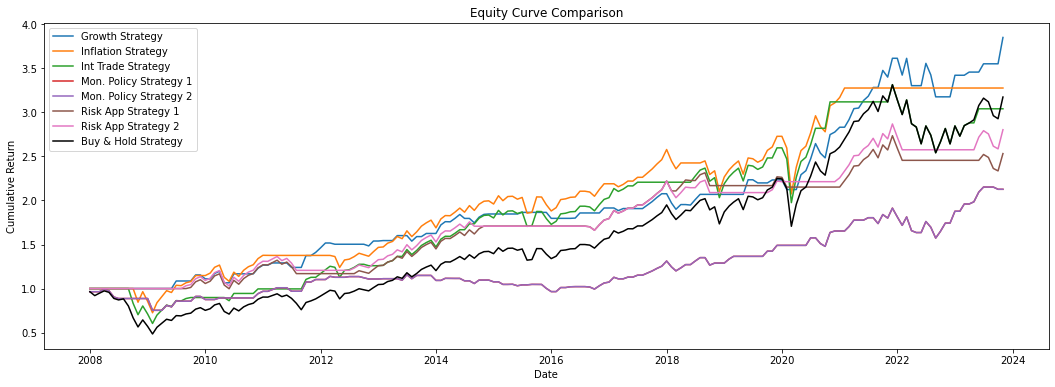

In [20]:
plt.figure(figsize=(18, 6))

plt.plot(data_final.index, data_final['Cumulative_Return_growth'], label='Growth Strategy')
plt.plot(data_final.index, data_final['Cumulative_Return_inf_12M_chg'], label='Inflation Strategy')
plt.plot(data_final.index, data_final['Cumulative_Return_trade_12M_chg'], label='Int Trade Strategy')
plt.plot(data_final.index, data_final['Cumulative_Return_mon_1M_chg'], label='Mon. Policy Strategy 1')
plt.plot(data_final.index, data_final['Cumulative_Return_mon_1M_diff'], label='Mon. Policy Strategy 2')
plt.plot(data_final.index, data_final['Cumulative_Return_risk_12M_chg'], label='Risk App Strategy 1')
plt.plot(data_final.index, data_final['Cumulative_Return_risk_12M_diff'], label='Risk App Strategy 2')


plt.plot(data_final.index, data_final['Cumulative_Return_Buy&Hold'], label='Buy & Hold Strategy', color='black')

plt.legend()
plt.title('Equity Curve Comparison')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.show()

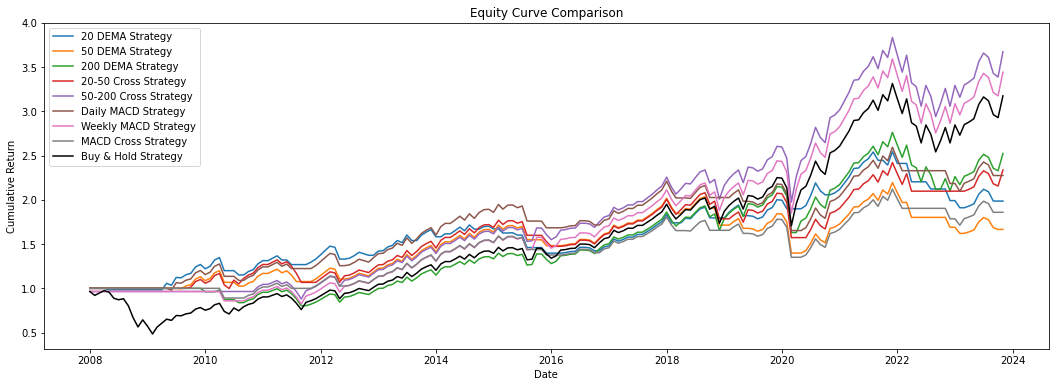

In [21]:
plt.figure(figsize=(18, 6))

plt.plot(data_final.index, data_final['Cumulative_Return_20DEMA'], label='20 DEMA Strategy')
plt.plot(data_final.index, data_final['Cumulative_Return_50DEMA'], label='50 DEMA Strategy')
plt.plot(data_final.index, data_final['Cumulative_Return_200DEMA'], label='200 DEMA Strategy')
plt.plot(data_final.index, data_final['Cumulative_Return_Crossover1'], label='20-50 Cross Strategy')
plt.plot(data_final.index, data_final['Cumulative_Return_Crossover2'], label='50-200 Cross Strategy')
plt.plot(data_final.index, data_final['Cumulative_Return_Daily_MACD'], label='Daily MACD Strategy')
plt.plot(data_final.index, data_final['Cumulative_Return_Weekly_MACD'], label='Weekly MACD Strategy')
plt.plot(data_final.index, data_final['Cumulative_Return_MACD'], label='MACD Cross Strategy')

plt.plot(data_final.index, data_final['Cumulative_Return_Buy&Hold'], label='Buy & Hold Strategy', color='black')

plt.legend()
plt.title('Equity Curve Comparison')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.show()

In [22]:
table = []

for strategy, metrics in ret_dd.items():
    annual_return, max_dd, annual_std = metrics
    sharpe_ratio = annual_return / annual_std
    table.append([strategy, f"{annual_return:.2f}%", f"{max_dd:.2f}%", f"{annual_std:.2f}%", f"{sharpe_ratio:.2f}"])

headers = ['Strategy', 'Annual Return', 'Max Drawdown', 'Annual Std Dev', 'Sharpe Ratio']
print(tabulate(table, headers=headers, tablefmt="grid"))

+---------------+-----------------+----------------+------------------+----------------+
| Strategy      | Annual Return   | Max Drawdown   | Annual Std Dev   |   Sharpe Ratio |
+===============+=================+================+==================+================+
| growth        | 8.84%           | -12.11%        | 10.23%           |           0.86 |
+---------------+-----------------+----------------+------------------+----------------+
| inf_12M_chg   | 7.74%           | -27.48%        | 15.33%           |           0.51 |
+---------------+-----------------+----------------+------------------+----------------+
| trade_12M_chg | 7.24%           | -39.64%        | 16.60%           |           0.44 |
+---------------+-----------------+----------------+------------------+----------------+
| mon_1M_chg    | 4.86%           | -24.07%        | 10.90%           |           0.45 |
+---------------+-----------------+----------------+------------------+----------------+
| mon_1M_diff   | 4.8

# 8. Multi Factor Model
<br>- Built a multifactor model based on approach mentioned below
<br>- Plot and compared the results of multi-factor approach vs the Buy and Hold Index

In [23]:
# Looked for combining factors with highest return and lowest dd but couldnt find a combination other than growth itself
# Looked for combining factors with highest return and lowest std (growth + risk app)
# Combined growth with crossover strategy 2 for economic + price model

data_final['Strategy_MultiFactor1'] = 0
data_final['Strategy_MultiFactor2'] = 0

for row in range(len(data_final)):
    if data_final['Strategy_growth'][row] == 1: # selecting combination of growth and risk appetite
        if data_final['Strategy_risk_12M_diff'][row] == 1:
            data_final['Strategy_MultiFactor1'][row] = 1

    if data_final['Strategy_growth'][row] == 1: # selecting combination of growth and 50/200 DEMA Crossover
            if data_final['Strategy_Crossover2'][row] == 1:
                data_final['Strategy_MultiFactor2'][row] = 1
                
data_final['Return_MultiFactor1'] = data_final['Strategy_MultiFactor1'] * data_final['price_1M_ret_curr']
data_final['Cumulative_Return_MultiFactor1'] = (1 + data_final['Return_MultiFactor1']).cumprod()

data_final['Return_MultiFactor2'] = data_final['Strategy_MultiFactor2'] * data_final['price_1M_ret_curr']
data_final['Cumulative_Return_MultiFactor2'] = (1 + data_final['Return_MultiFactor2']).cumprod()

ret_dd['multifactor1'] = (annualized_return(data_final['Cumulative_Return_MultiFactor1']) * 100,
                         max_drawdown(data_final['Cumulative_Return_MultiFactor1']) * 100,
                         annualized_std(data_final['Cumulative_Return_MultiFactor1']) * 100)

ret_dd['multifactor2'] = (annualized_return(data_final['Cumulative_Return_MultiFactor2']) * 100,
                         max_drawdown(data_final['Cumulative_Return_MultiFactor2']) * 100,
                         annualized_std(data_final['Cumulative_Return_MultiFactor2']) * 100)

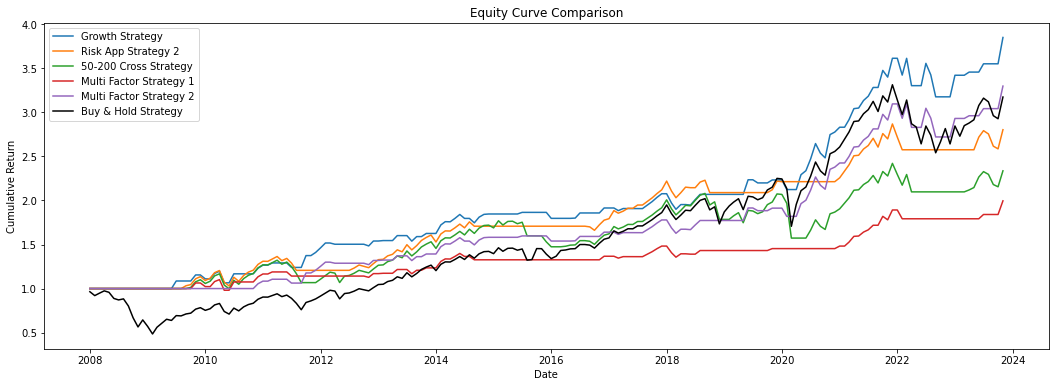

In [24]:
plt.figure(figsize=(18, 6))

plt.plot(data_final.index, data_final['Cumulative_Return_growth'], label='Growth Strategy')
plt.plot(data_final.index, data_final['Cumulative_Return_risk_12M_diff'], label='Risk App Strategy 2')
plt.plot(data_final.index, data_final['Cumulative_Return_Crossover1'], label='50-200 Cross Strategy')
plt.plot(data_final.index, data_final['Cumulative_Return_MultiFactor1'], label='Multi Factor Strategy 1')
plt.plot(data_final.index, data_final['Cumulative_Return_MultiFactor2'], label='Multi Factor Strategy 2')

plt.plot(data_final.index, data_final['Cumulative_Return_Buy&Hold'], label='Buy & Hold Strategy', color='black')

plt.legend()
plt.title('Equity Curve Comparison')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.show()

# 9. Final Results:
<br>- Tabulated the results of all the discussed 18 strategies

In [25]:
table = []

for strategy, metrics in ret_dd.items():
    annual_return, max_dd, annual_std = metrics
    sharpe_ratio = annual_return / annual_std
    table.append([strategy, f"{annual_return:.2f}%", f"{max_dd:.2f}%", f"{annual_std:.2f}%", f"{sharpe_ratio:.2f}"])

headers = ['Strategy', 'Annual Return', 'Max Drawdown', 'Annual Std Dev', 'Sharpe Ratio']
print(tabulate(table, headers=headers, tablefmt="grid"))

+---------------+-----------------+----------------+------------------+----------------+
| Strategy      | Annual Return   | Max Drawdown   | Annual Std Dev   |   Sharpe Ratio |
+===============+=================+================+==================+================+
| growth        | 8.84%           | -12.11%        | 10.23%           |           0.86 |
+---------------+-----------------+----------------+------------------+----------------+
| inf_12M_chg   | 7.74%           | -27.48%        | 15.33%           |           0.51 |
+---------------+-----------------+----------------+------------------+----------------+
| trade_12M_chg | 7.24%           | -39.64%        | 16.60%           |           0.44 |
+---------------+-----------------+----------------+------------------+----------------+
| mon_1M_chg    | 4.86%           | -24.07%        | 10.90%           |           0.45 |
+---------------+-----------------+----------------+------------------+----------------+
| mon_1M_diff   | 4.8

# 10. Signal Analyzer
<br>- Analyzed how the price returns vary with respect to the final factors chosen for multi-factor timing model

array([[<AxesSubplot:xlabel='DATE'>],
       [<AxesSubplot:xlabel='DATE'>],
       [<AxesSubplot:xlabel='DATE'>],
       [<AxesSubplot:xlabel='DATE'>],
       [<AxesSubplot:xlabel='DATE'>],
       [<AxesSubplot:xlabel='DATE'>],
       [<AxesSubplot:xlabel='DATE'>],
       [<AxesSubplot:xlabel='DATE'>]], dtype=object)

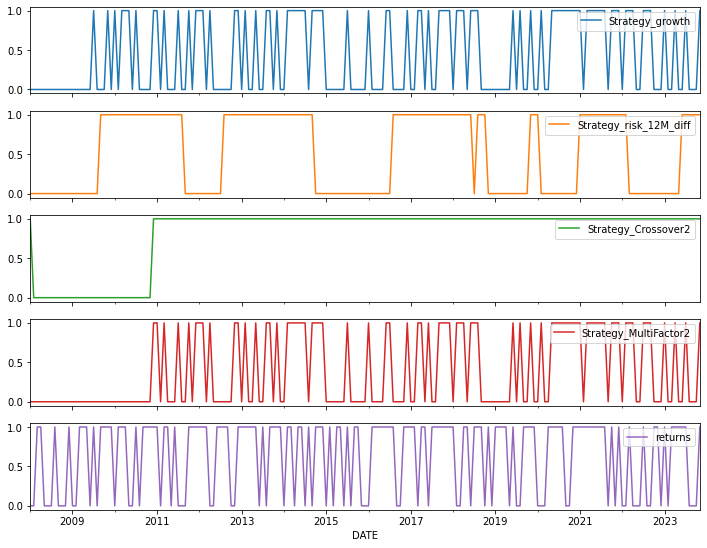

In [26]:
# Analyzing strategies with respect to positive returns
data_final[['Strategy_growth',
            'Strategy_risk_12M_diff',
            'Strategy_Crossover2',
            'Strategy_MultiFactor2',
            'returns']].plot(subplots=True, layout=(8,1), figsize=(12, 15))